# 🎬 네이버 영화리뷰 감성분석 도전하기

노드실습때는 영문 텍스트의 감정분석을 해봤다. 이번 프로젝트에서는 한국어 텍스트의 감정분석을 진행해보려한다.

## 1) 데이터 준비와 확인

프로젝트에 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus다.

In [24]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

실슬때는 가공된 데이터를 사용했지만 프로젝트에서는 가공되지 않은 파일로 구성돼있기 때문에 다음의 기능을 포함한다.
> - 데이터 중복 제거
> - 결측치 제거
> - 토크나이저로 토큰화
> - word_to_index 구성
> - 텍스트 문자열을 사전 인덱스 스트링으로 변환

In [25]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

In [32]:
index_to_word = {index:word for word, index in word_to_index.items()}
for key, ind in enumerate(index_to_word):
    print(key, index_to_word[ind])
    if ind == 10:
        break

0 <PAD>
1 <BOS>
2 <UNK>
3 <UNUSED>
4 .
5 영화
6 다
7 고
8 하
9 을
10 보


In [4]:
print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))


146182
146182
49157
49157


In [5]:
print(len(x_train))
print(len(x_test))

146182
49157


In [6]:
y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_train.shape)
print(y_test.shape)

(146182,)
(49157,)


## 3) 모델구성을 위한 데이터 분석 및 가공

In [7]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

In [8]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

In [10]:
print(x_train.shape)
x_train

(146182, 41)


array([[  32,   74,  919, ...,    0,    0,    0],
       [1028,    4,   11, ...,    0,    0,    0],
       [  24,  205,    2, ...,    0,    0,    0],
       ...,
       [ 154,    2,   18, ...,    0,    0,    0],
       [1052,    5, 2516, ...,    0,    0,    0],
       [ 181,    5, 1945, ...,    0,    0,    0]], dtype=int32)

In [11]:
print(x_test.shape)
x_test

(49157, 41)


array([[ 832,  130,    0, ...,    0,    0,    0],
       [   2,    0,    0, ...,    0,    0,    0],
       [  85,  111,   58, ...,    0,    0,    0],
       ...,
       [1039,   19,    7, ...,    0,    0,    0],
       [ 418,  492,   27, ...,    0,    0,    0],
       [1009,  179,   63, ...,    0,    0,    0]], dtype=int32)

## 4) 모델 구성 및 validation set 구성

RNN, GlobalMaxPooling1D(), 1-D Convolution Neural Network(1-D CNN) 세가지 모델을 활용해 워드 임베딩을 사용하지 않은 방법으로 학습시켜보자.

In [12]:
# validation set 10000건 분리
x_val = x_train[:36545]   
y_val = y_train[:36545]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[36545:]  
partial_y_train = y_train[36545:]


print(x_val.shape)
print(partial_x_train.shape)

x_val.shape[0] + partial_x_train.shape[0]

(36545, 41)
(109637, 41)


146182

### 4-1) RNN model

In [177]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8)) 
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
lstm_18 (LSTM)               (None, 8)                 9888      
_________________________________________________________________
dense_50 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [178]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 11s 44ms/step - loss: 0.6329 - accuracy: 0.6061 - val_loss: 0.3967 - val_accuracy: 0.8409
Epoch 2/10
215/215 [==============================] - 9s 42ms/step - loss: 0.3590 - accuracy: 0.8585 - val_loss: 0.3506 - val_accuracy: 0.8514
Epoch 3/10
215/215 [==============================] - 9s 42ms/step - loss: 0.2965 - accuracy: 0.8825 - val_loss: 0.3396 - val_accuracy: 0.8552
Epoch 4/10
215/215 [==============================] - 9s 42ms/step - loss: 0.2607 - accuracy: 0.8967 - val_loss: 0.3408 - val_accuracy: 0.8556
Epoch 5/10
215/215 [==============================] - 9s 42ms/step - loss: 0.2301 - accuracy: 0.9100 - val_loss: 0.3478 - val_accuracy: 0.8553
Epoch 6/10
215/215 [==============================] - 9s 42ms/step - loss: 0.2038 - accuracy: 0.9213 - val_loss: 0.3684 - val_accuracy: 0.8534
Epoch 7/10
215/215 [==============================] - 9s 42ms/step - loss: 0.1790 - accuracy: 0.9317 - val_loss: 0.4085 - val_accuracy: 0.851

In [179]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4936 - accuracy: 0.8438
[0.49360260367393494, 0.8438472747802734]


In [180]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


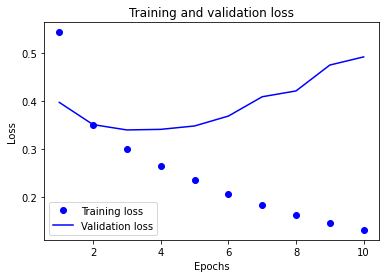

In [181]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

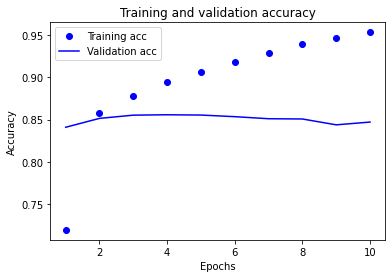

In [182]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4-2) GlobalMaxPooling1D()

In [170]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 300)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [171]:
print(x_val.shape)
print(partial_x_train.shape)

(36545, 41)
(109637, 41)


In [172]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 9s 37ms/step - loss: 0.5705 - accuracy: 0.7354 - val_loss: 0.3475 - val_accuracy: 0.8492
Epoch 2/10
215/215 [==============================] - 8s 37ms/step - loss: 0.3145 - accuracy: 0.8678 - val_loss: 0.3354 - val_accuracy: 0.8546
Epoch 3/10
215/215 [==============================] - 8s 36ms/step - loss: 0.2527 - accuracy: 0.9008 - val_loss: 0.3432 - val_accuracy: 0.8557
Epoch 4/10
215/215 [==============================] - 8s 37ms/step - loss: 0.2097 - accuracy: 0.9226 - val_loss: 0.3591 - val_accuracy: 0.8545
Epoch 5/10
215/215 [==============================] - 8s 37ms/step - loss: 0.1627 - accuracy: 0.9449 - val_loss: 0.3820 - val_accuracy: 0.8542
Epoch 6/10
215/215 [==============================] - 8s 37ms/step - loss: 0.1185 - accuracy: 0.9628 - val_loss: 0.4200 - val_accuracy: 0.8506
Epoch 7/10
215/215 [==============================] - 8s 36ms/step - loss: 0.0820 - accuracy: 0.9788 - val_loss: 0.4577 - val_accuracy: 0.8482

In [173]:
results2 = model2.evaluate(x_test,  y_test, verbose=2)

print(results2)

1537/1537 - 3s - loss: 0.5873 - accuracy: 0.8386
[0.5872730612754822, 0.8386394381523132]


In [174]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


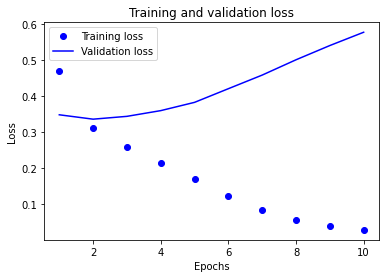

In [175]:
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

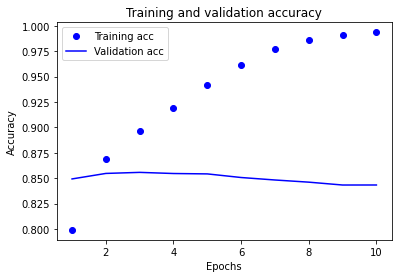

In [176]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4-3) 1-D Convolution Neural Network(1-D CNN)

In [167]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_47 (Dense)             (None, 1)               

In [168]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 15s 59ms/step - loss: 0.5685 - accuracy: 0.6879 - val_loss: 0.3463 - val_accuracy: 0.8482
Epoch 2/10
215/215 [==============================] - 9s 43ms/step - loss: 0.3040 - accuracy: 0.8743 - val_loss: 0.3299 - val_accuracy: 0.8562
Epoch 3/10
215/215 [==============================] - 9s 44ms/step - loss: 0.2384 - accuracy: 0.9070 - val_loss: 0.3432 - val_accuracy: 0.8541
Epoch 4/10
215/215 [==============================] - 9s 43ms/step - loss: 0.1681 - accuracy: 0.9397 - val_loss: 0.3900 - val_accuracy: 0.8516
Epoch 5/10
215/215 [==============================] - 9s 43ms/step - loss: 0.1151 - accuracy: 0.9608 - val_loss: 0.4505 - val_accuracy: 0.8446
Epoch 6/10
215/215 [==============================] - 9s 43ms/step - loss: 0.0753 - accuracy: 0.9761 - val_loss: 0.5194 - val_accuracy: 0.8446
Epoch 7/10
215/215 [==============================] - 9s 43ms/step - loss: 0.0522 - accuracy: 0.9843 - val_loss: 0.5942 - val_accuracy: 0.842

In [169]:
results_cnn = model_cnn.evaluate(x_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 5s - loss: 0.8252 - accuracy: 0.8298
[0.8251777291297913, 0.8297902345657349]


In [159]:
history_dict_cnn = history_cnn.history
print(history_dict_cnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


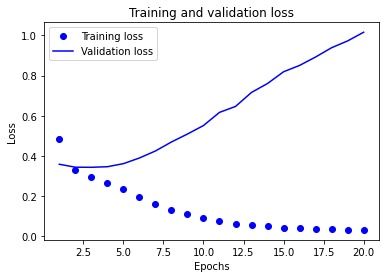

In [160]:
acc = history_dict_cnn['accuracy']
val_acc = history_dict_cnn['val_accuracy']
loss = history_dict_cnn['loss']
val_loss = history_dict_cnn['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

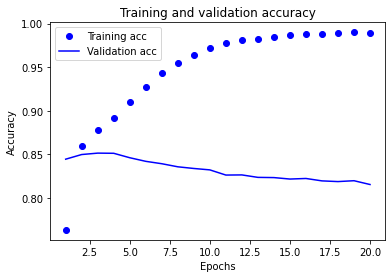

In [161]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

> 파라미터 변경, 워드 임베딩을 사용하지 않았을때 생각보다 acc가 높지 않았다.

## 5) 학습된 Embedding 레이어 분석

- 개인적인 생각으로는 벡터가 16차원으로 축소되면서 중요한 정보를 잃었다고 생각이 들었다. 
  점점 차원수를 늘려가면서 acc와 loss값에 변화가 있는지 확인해보려한다.
  가장 인식률이 좋았던 LSTM layer의 임베딩 벡터 사이즈를 변경 해보자. 

-  또한 에포크가 너무커서 과적합이 일어날 수 있기때문에 변화를 주었다.

### 5-1) vector size 변경

위에서 3개의 모델을 맨처음에 구성할때 vector size를 16, epoch를 20으로 줬었는데, vector size를 300, epoch를 10으로 각각 변화를 주었다.

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 500  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_vec_200 = keras.Sequential()
model_vec_200.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_vec_200.add(keras.layers.LSTM(8)) 
model_vec_200.add(keras.layers.Dense(8, activation='relu'))
model_vec_200.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_vec_200.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 500)         5000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 16288     
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 5,016,369
Trainable params: 5,016,369
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_vec_200.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_vec_200 = model_vec_200.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 17s 66ms/step - loss: 0.6536 - accuracy: 0.5858 - val_loss: 0.5589 - val_accuracy: 0.7716
Epoch 2/10
215/215 [==============================] - 14s 63ms/step - loss: 0.5006 - accuracy: 0.7905 - val_loss: 0.4272 - val_accuracy: 0.8068
Epoch 3/10
215/215 [==============================] - 14s 64ms/step - loss: 0.4182 - accuracy: 0.8271 - val_loss: 0.3785 - val_accuracy: 0.8393
Epoch 4/10
215/215 [==============================] - 14s 63ms/step - loss: 0.3253 - accuracy: 0.8693 - val_loss: 0.3663 - val_accuracy: 0.8459
Epoch 5/10
215/215 [==============================] - 14s 64ms/step - loss: 0.2840 - accuracy: 0.8876 - val_loss: 0.3578 - val_accuracy: 0.8482
Epoch 6/10
215/215 [==============================] - 15s 68ms/step - loss: 0.2634 - accuracy: 0.8969 - val_loss: 0.3630 - val_accuracy: 0.8490
Epoch 7/10
215/215 [==============================] - 14s 64ms/step - loss: 0.2421 - accuracy: 0.9056 - val_loss: 0.3779 - val_accuracy:

In [16]:
results_vec_200 = model_vec_200.evaluate(x_test,  y_test, verbose=2)

print(results_vec_200)

1537/1537 - 5s - loss: 0.4472 - accuracy: 0.8404
[0.4472179114818573, 0.8403889536857605]


In [18]:
history_dict_vec_200 = history_vec_200.history
print(history_dict_vec_200.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


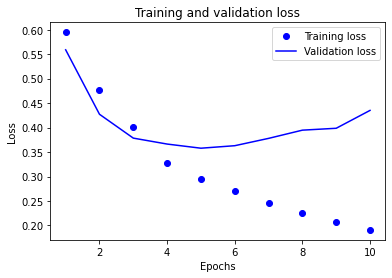

In [19]:
acc = history_dict_vec_200['accuracy']
val_acc = history_dict_vec_200['val_accuracy']
loss = history_dict_vec_200['loss']
val_loss = history_dict_vec_200['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

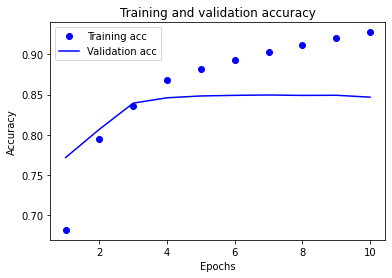

In [20]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 5-2) dropout layer 추가

EX1 시간에  dropout layer를 사용하면 과적합문제에 도움이 된다고 배웠던 기억이 생각나,
LSTM 레이어 뒤에 dropout레이어를 추가했다. 마찬가지로 성능이 제일 좋았던 LSTM모델을 사용했다.

In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_drop = keras.Sequential()
model_drop.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_drop.add(keras.layers.LSTM(8)) 
model_drop.add(keras.layers.Dropout(0.4))
model_drop.add(keras.layers.Dense(8, activation='relu'))
model_drop.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_drop.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_drop.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_drop = model_drop.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 11s 42ms/step - loss: 0.6714 - accuracy: 0.5483 - val_loss: 0.4481 - val_accuracy: 0.8136
Epoch 2/10
215/215 [==============================] - 8s 39ms/step - loss: 0.4232 - accuracy: 0.8269 - val_loss: 0.3542 - val_accuracy: 0.8473
Epoch 3/10
215/215 [==============================] - 9s 40ms/step - loss: 0.3333 - accuracy: 0.8669 - val_loss: 0.3544 - val_accuracy: 0.8476
Epoch 4/10
215/215 [==============================] - 9s 40ms/step - loss: 0.3041 - accuracy: 0.8779 - val_loss: 0.3481 - val_accuracy: 0.8516
Epoch 5/10
215/215 [==============================] - 9s 40ms/step - loss: 0.2731 - accuracy: 0.8920 - val_loss: 0.3577 - val_accuracy: 0.8530
Epoch 6/10
215/215 [==============================] - 9s 40ms/step - loss: 0.2446 - accuracy: 0.9028 - val_loss: 0.3602 - val_accuracy: 0.8540
Epoch 7/10
215/215 [==============================] - 9s 40ms/step - loss: 0.2230 - accuracy: 0.9130 - val_loss: 0.3767 - val_accuracy: 0.854

In [30]:
results_drop = model_drop.evaluate(x_test,  y_test, verbose=2)

print(results_drop)

1537/1537 - 5s - loss: 0.4620 - accuracy: 0.8447
[0.4619992673397064, 0.8447423577308655]


In [31]:
history_dict_drop = history_drop.history
print(history_dict_drop.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


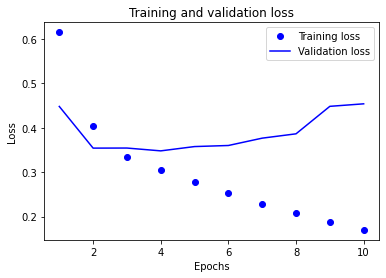

In [32]:
acc = history_dict_drop['accuracy']
val_acc = history_dict_drop['val_accuracy']
loss = history_dict_drop['loss']
val_loss = history_dict_drop['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

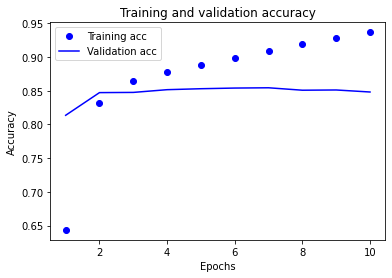

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

> dropout layer를 임베딩 레이어 직후에 넣으니까 test acc 성능이 매우 안좋았다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

- 사전에 학습된 Word2Vec 임베딩 모델을 활용하는 전이학습을 사용한 이뉴는 광범위한 데이터를 통해 미리
  학습해놓은 임베딩 속에 녹아있는 정보를 사용하면 훨씩 빠르고 정확하게 학습할 수 있기 때문에,
  한국어 Word2Vec 임베딩 모델을 사용해보자.

In [13]:
from gensim.models import KeyedVectors
import gensim

print(gensim.__version__)

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec['컴퓨터']
vector

3.8.3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [14]:
word2vec.similar_by_word("직업")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('전문직', 0.7164889574050903),
 ('직종', 0.6679812669754028),
 ('취업', 0.6223794221878052),
 ('직업인', 0.6074769496917725),
 ('직장', 0.5814609527587891),
 ('자격증', 0.5592581629753113),
 ('사무직', 0.549869179725647),
 ('성별', 0.5446053743362427),
 ('자질', 0.536906361579895),
 ('직장인', 0.5329881906509399)]

In [18]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [19]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model_gen1 = keras.Sequential()
model_gen1.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_gen1.add(keras.layers.LSTM(8)) 
model_gen1.add(keras.layers.Dense(8, activation='relu'))
model_gen1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gen1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_gen1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gen1 = model_gen1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 8s 31ms/step - loss: 0.6772 - accuracy: 0.5482 - val_loss: 0.4804 - val_accuracy: 0.7922
Epoch 2/10
215/215 [==============================] - 6s 29ms/step - loss: 0.4305 - accuracy: 0.8173 - val_loss: 0.3822 - val_accuracy: 0.8335
Epoch 3/10
215/215 [==============================] - 6s 29ms/step - loss: 0.3432 - accuracy: 0.8587 - val_loss: 0.3582 - val_accuracy: 0.8450
Epoch 4/10
215/215 [==============================] - 6s 29ms/step - loss: 0.3107 - accuracy: 0.8731 - val_loss: 0.3549 - val_accuracy: 0.8481
Epoch 5/10
215/215 [==============================] - 6s 30ms/step - loss: 0.2928 - accuracy: 0.8822 - val_loss: 0.3557 - val_accuracy: 0.8482
Epoch 6/10
215/215 [==============================] - 6s 29ms/step - loss: 0.2784 - accuracy: 0.8891 - val_loss: 0.3578 - val_accuracy: 0.8479
Epoch 7/10
215/215 [==============================] - 6s 29ms/step - loss: 0.2668 - accuracy: 0.8948 - val_loss: 0.3627 - val_accuracy: 0.8480

In [21]:
results_gen1 = model_gen1.evaluate(x_test,  y_test, verbose=2)

print(results_gen1)

1537/1537 - 5s - loss: 0.3917 - accuracy: 0.8430
[0.39166492223739624, 0.8430132269859314]


워드 임베딩을 사용해서 성능을 개선해보려 했지만 큰 변화가없었다.   
이번에는 위에서 시도해본 dropout layer를 추가해보려한다.

### 8-2) Word2Vec 임베딩모델에 dropout 추가

In [192]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model_gen = keras.Sequential()
model_gen.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_gen.add(keras.layers.LSTM(8)) 
model_gen.add(keras.layers.Dropout(0.4))
model_gen.add(keras.layers.Dense(8, activation='relu'))
model_gen.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gen.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 8)                 6688      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [193]:
model_gen.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gen = model_gen.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 9s 32ms/step - loss: 0.6953 - accuracy: 0.5010 - val_loss: 0.6924 - val_accuracy: 0.5080
Epoch 2/10
215/215 [==============================] - 6s 30ms/step - loss: 0.6920 - accuracy: 0.5039 - val_loss: 0.6027 - val_accuracy: 0.6906
Epoch 3/10
215/215 [==============================] - 7s 30ms/step - loss: 0.5402 - accuracy: 0.7368 - val_loss: 0.4051 - val_accuracy: 0.8235
Epoch 4/10
215/215 [==============================] - 6s 30ms/step - loss: 0.3889 - accuracy: 0.8397 - val_loss: 0.3570 - val_accuracy: 0.8494
Epoch 5/10
215/215 [==============================] - 6s 30ms/step - loss: 0.3379 - accuracy: 0.8664 - val_loss: 0.3493 - val_accuracy: 0.8530
Epoch 6/10
215/215 [==============================] - 6s 30ms/step - loss: 0.3140 - accuracy: 0.8815 - val_loss: 0.3625 - val_accuracy: 0.8462
Epoch 7/10
215/215 [==============================] - 6s 30ms/step - loss: 0.2999 - accuracy: 0.8860 - val_loss: 0.3506 - val_accuracy: 0.8531

In [194]:
results_gen = model_gen.evaluate(x_test,  y_test, verbose=2)

print(results_gen)

1537/1537 - 5s - loss: 0.3659 - accuracy: 0.8513
[0.36587464809417725, 0.8513131141662598]


In [195]:
history_dict_gen = history_gen.history
print(history_dict_gen.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


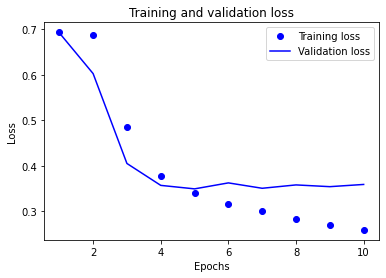

In [196]:
acc = history_dict_gen['accuracy']
val_acc = history_dict_gen['val_accuracy']
loss = history_dict_gen['loss']
val_loss = history_dict_gen['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

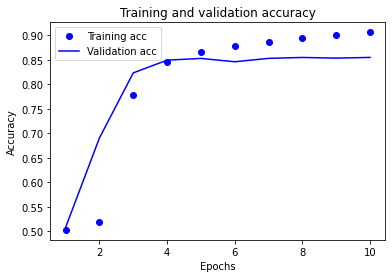

In [197]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

dropout layer를 적용하니 과적합이 줄은 모습을 그래프로 확인할 수 있었다.    
acc도 85.1%로 위에서 시도해본 모델보다 개선된 모습을 보였다.

## 회고

> - overfitting(과적함)은 기계학습에서 학습 데이터를 과하게 학습하는것을 뜻한다. 너무 세밀하게 학습 데이터 하나하나를 다 설명하려고 하다보니 정작 중요한 패턴을 설명할 수 없게 되는 현상
> - embedding vector란 단어의 의미를 다차원 공간에 벡처화 하는방법을 분산표현이라고도 하며 분산표현을 이용해 단어의 유사도를 벡터화 하는
작업은 워드 임베딩작업에 속하기 때문에 이렇게 표현된 벡터 또한 임베딩 벡터라고 한다.
> - embedding vector가 너무 작으면 acc가 떨어졌다. 적당한 vector size가 필요했었다.
> - 처음에 epoch값을 크게주어 학습횟수가 많았을때 그래프상으로 train그래프와 validation 그래프가 점점 멀어지는 선을 그렸다. 과한 epoch는   acc를 떨어트렸다.
> - dropout을 추가를 안했을때는 acc, loss그래프가 튀는 모습을 볼 수 있었다. 추가를 했을때는 오버피팅을 방지하는 모습을 볼 수 있었다. 과한 dropout은 좋지 않았다.